In [1]:
pip install pandas matplotlib numpy seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from utils import *

# Data source

In [3]:
root_dir = "/local/workspace/automation/benchmarks/benchmarks/EUROSYS23-DATA/"
data_root_dir = root_dir

out_dir = "/local/workspace/automation/plot" + os.sep + "plots"
os.makedirs(out_dir, exist_ok=True)
print(out_dir)

dirs = {}
dirs['ow'] = {}
dirs['ow']['latency'] = {"python":"latency/latency-python",
                         "node":"latency/latency-node-no-gc",
                         "pyperf":"latency/latency-pyperf",
                         "polybench":"latency/latency-c"}
dirs['ow']['xput'] = {"python":"xput/xput-python-long",
                      "node":"xput/xput-node-no-gc-long",
                      "pyperf":"xput/xput-pyperf-long",
                      "polybench":"xput/xput-polybench-o3-long"}
dirs['ow']['scaling'] = {"1":"scaling/scaling-1",
                         "2":"scaling/scaling-2",
                         "3":"scaling/scaling-3",
                         "4":"scaling/scaling-4"}
dirs['faasm'] = {}
dirs['faasm']['invoker-latency'] = {"all": "faasm/faasm-invoker-latencies"}
dirs['faasm']['e2e-latency'] = {"pyperf":"faasm/faasm-e2e-pyperf",
                               "polybench":"faasm/faasm-e2e-polybench"}
dirs['micro'] = {}
dirs['micro']['dirty'] = {"dirty-percent-fast":"microbenchmarks/micro-dirty-batch-thpt/*",
                     "dirty-percent-slow":"microbenchmarks/micro-dirty-batch-paused/*"}
dirs['micro']['vm-size'] = {"vary-vm-size-fast":"microbenchmarks/micro-vm-size-batch/*",
                            "vary-vm-size-slow":"microbenchmarks/micro-vm-size-paused/*"}

/local/workspace/automation/plot/plots


# Microbenchmarks

In [4]:
microbenchmarks_col = ['#5e3c99', '#b2abd2', '#377eb8', '#fdb863']
def get_var(f, var):
    return f.split(var)[-1].split("-")[0][1:].replace(".csv","")

def prepare_microplots(sysname, var, paths, xlabel, multiplier = 1, legend=True, legend_start=0):
    if not isinstance(paths, list):
        paths = [paths]
    ax = None
    lsty = ['-','--']
    for path in paths:
        dirs = sorted(glob(data_root_dir  + os.sep + path))
        print(len(dirs))
        all_non_inst_dirs = []
        for di in dirs:
            all_non_inst_dirs.extend(sorted(glob(di + os.sep + "*/*")))
        forkline_dirs=[d for d in all_non_inst_dirs if "_forkline" in d]
        baseline_dirs=[d for d in all_non_inst_dirs if "_baseline" in d]
        gh_nop_dirs=[d for d in all_non_inst_dirs if "_gh-nop" in d]
        sd_dirs=[d for d in all_non_inst_dirs if "_groundhog-sd" in d]
        len(baseline_dirs),len(forkline_dirs),len(sd_dirs),len(gh_nop_dirs)
        dfs = []

        dirs_list = [baseline_dirs, forkline_dirs, gh_nop_dirs, sd_dirs]
        dirs_names = ["baseline", "forkline", "GH-NOP", "GH"]
        for g in range(len(dirs_list)):
            for i,r in enumerate(dirs_list[g]):
                files = glob(r + os.sep + "*.csv")
                for f in files:
                    df = pd.read_csv(f)
                    df['type'] = dirs_names[g]
                    df[var] = int(get_var(f,var)) * multiplier
                    df['iteration'] = i
                    dfs.append(mark_checkpoints(df))
        df = pd.concat(dfs)

        df_success = df.query('statusCode == True or statusCode == 0')
        df_success['TrueTime'] = df_success['TrueTime'] / 1e6
        df_grouped = df_success.groupby(['name', 'type', 'iteration', 'invocation_type', var])
        df_grouped = df_success.groupby(['name', 'type', 'invocation_type', var])

        plots=["duration"]
        ylabels=["Latency (ms)"]
        fnames = ["invoker"]
        for i in range(len(plots)):
            print(i, plots[i])
            df_successdata_m = df_grouped.mean().reset_index().query('invocation_type == "warm"')
            df_successdata_e = df_grouped.std().reset_index().query('invocation_type == "warm"')
            pt_df_m = df_successdata_m.pivot_table(index=var, columns='type', values=plots[i])
            pt_df_e = df_successdata_e.pivot_table(index=var, columns='type', values=plots[i])
            if ax == None:
                ax = pt_df_m.plot(yerr=pt_df_e, capsize=5, lw=3, kind='line', legend=None, figsize=(7,5),
                                  linestyle=lsty.pop(), color=microbenchmarks_col)
            else:
                ax = pt_df_m.plot(yerr=pt_df_e, capsize=5, lw=3, kind='line', legend=None,
                                      linestyle=lsty.pop(), color=microbenchmarks_col, ax = ax)
            plt.ylabel("Latency (ms)",fontsize=20)
            plt.xlabel(xlabel,fontsize=20)

    # get handles
    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]#[legend_start:legend_start+4]
    
    order=[3,0,1,2,7,4,5,6][legend_start:legend_start+4]
    for l in range(0,4):
        labels[l] = labels[l]+ " (+restoration)"
    if legend:
        legend = plt.legend([handles[idx] for idx in order],[labels[idx].replace("line","") for idx in order],loc='upper left',
                   numpoints=1, ncol=1, title="",prop={'size': 20}) 
        legend.get_frame().set_facecolor('none')
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=24)
    plt.tight_layout()

    plt.savefig(out_dir + os.sep + "micro-"+var+"-"+fnames[i]+"-"+sysname+"-overlay-invoker-paper.png",bbox_inches="tight")
    plt.savefig(out_dir + os.sep + "micro-"+var+"-"+fnames[i]+"-"+sysname+"-overlay-invoker-paper.pdf",bbox_inches="tight")

1
0 duration
1


findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.


0 duration


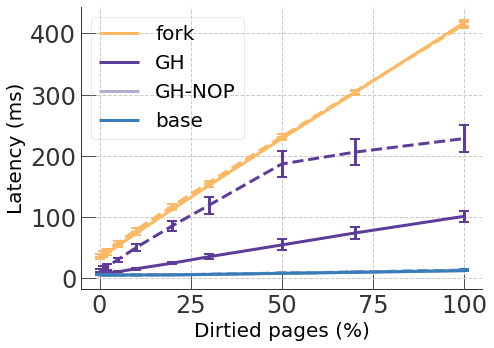

In [5]:
prepare_microplots("restore_inclusive", "dirty", [dirs['micro']['dirty']["dirty-percent-fast"],dirs['micro']['dirty']["dirty-percent-slow"]] ,"Dirtied pages (%)", legend_start=4)

1
0 duration
1
0 duration


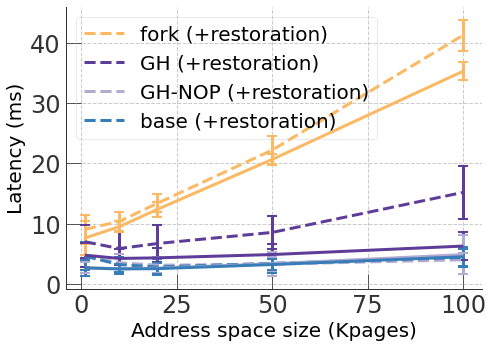

In [6]:
prepare_microplots("restore_inclusive", "npages", [dirs['micro']['vm-size']["vary-vm-size-fast"], dirs['micro']['vm-size']["vary-vm-size-slow"]], "Address space size (Kpages)", 0.100)

# Latency Macrobenchmarks

#### Prepare Latency dfs (OW)

In [7]:
data_latency_poly_o3_file = glob(data_root_dir + dirs['ow']['latency']['polybench']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_latency_pyperf_file = glob(data_root_dir + dirs['ow']['latency']['pyperf']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_latency_python_file = glob(data_root_dir + dirs['ow']['latency']['python']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_latency_node_file = glob(data_root_dir + dirs['ow']['latency']['node']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]

In [8]:
df_latency_poly_o3 = pd.read_csv(data_latency_poly_o3_file)
df_latency_pyperf = pd.read_csv(data_latency_pyperf_file)
df_latency_python = pd.read_csv(data_latency_python_file)
df_latency_node = pd.read_csv(data_latency_node_file)
df_latency_ow = pd.concat([df_latency_poly_o3, df_latency_pyperf, df_latency_python, df_latency_node])

#### Prepare e2e latency dfs (Faasm)

In [9]:
data_faasm_e2e_latency_pyperf_files = [f for f in glob(data_root_dir + dirs['faasm']['e2e-latency']['pyperf'] + "*/*")
                                       if "-c1-r1" in f]
data_faasm_e2e_latency_polybench_files = [f for f in glob(data_root_dir + dirs['faasm']['e2e-latency']['polybench'] + "*/*")
                                       if "-c1-r1" in f]

In [10]:
all_faasm_pyperf_latency_dfs = []
for f in data_faasm_e2e_latency_pyperf_files:
    tmp_df = pd.read_json(f)
    tmp_df['name'] = '-'.join(re.sub("-t.","",f.split('/')[-1]).split('-')[0:-2]+["python"])
    tmp_df['type']="faasm"
    tmp_df['invocation_type'] = 'warm'
    tmp_df = tmp_df[tmp_df.end_end_latency/tmp_df.end_end_latency.mean() <= 1.2]
    all_faasm_pyperf_latency_dfs.append(tmp_df)
df_faasm_latency_pyperf = pd.concat(all_faasm_pyperf_latency_dfs)

In [11]:
all_faasm_polybench_latency_dfs = []
for f in data_faasm_e2e_latency_polybench_files:
    try:
        tmp_df = pd.read_json(f)
        tmp_df['name'] = '-'.join(re.sub("-t.","",f.split('/')[-1]).split('-')[0:-2]+["c"])
        tmp_df['type']="faasm"
        tmp_df['invocation_type'] = 'warm'
        tmp_df = tmp_df[tmp_df.end_end_latency/tmp_df.end_end_latency.mean() <= 1.2]
        all_faasm_polybench_latency_dfs.append(tmp_df)
    except Exception:
        pass
df_faasm_latency_polybench = pd.concat(all_faasm_polybench_latency_dfs)

In [12]:
df_faasm_e2e_latency = pd.concat([df_faasm_latency_pyperf,df_faasm_latency_polybench])

#### Prepare invoker latency dfs (Faasm)

In [13]:
faasm_pyperf_file = data_root_dir + dirs['faasm']['invoker-latency']['all']+os.sep+"pyperf_invoker.csv"
faasm_polybench_file = data_root_dir + dirs['faasm']['invoker-latency']['all']+os.sep+"polybench_invoker.csv"
faasm_df_pyperf = pd.read_csv(faasm_pyperf_file).rename(columns = {"Function":"name","Execution (us)":"duration"})
faasm_df_pyperf['name'] = faasm_df_pyperf['name'] + "-python"
faasm_df_polybench = pd.read_csv(faasm_polybench_file).rename(columns = {"Function":"name","Execution (us)":"duration"})
faasm_df_polybench['name'] = faasm_df_polybench['name'] + "-c"
df_faasm_invoker_latency = pd.concat([faasm_df_pyperf,faasm_df_polybench])
df_faasm_invoker_latency['duration'] = df_faasm_invoker_latency['duration']/1e3
df_faasm_invoker_latency['mean_ms'] = df_faasm_invoker_latency['Reset (us)']/1e3
df_faasm_invoker_latency['type']="faasm"
df_faasm_invoker_latency['invocation_type'] = 'warm'
df_faasm_invoker_latency['TrueTime'] =df_faasm_invoker_latency['duration'] *1e6

### Latency Plots

In [14]:
full_latency_df = pd.concat([df_latency_ow[['name','invocation_type', 'type', 'duration', 'end_end_latency', 'TrueTime']], df_faasm_e2e_latency, df_faasm_invoker_latency])
full_latency_df = full_latency_df.replace(["pyperf-", "bench_", "poly_", "polybench-", "-python", "-c$", "-node"],["", "", "", "", " (p)", " (c)", " (n)"],regex=True)

In [15]:
data = benchmarks_renamer(full_latency_df).copy()
df_grouped2 = data.groupby(['type','name'])

In [16]:
m = df_grouped2.mean().reset_index().query("type in ['warm-baseline','faasm', 'warm-GH', 'warm-GH-NOP', 'warm-forkline']")#.set_index('name').reindex(grand_table_order).reset_index()
e = df_grouped2.std().reset_index().query("type in ['warm-baseline','faasm', 'warm-GH', 'warm-GH-NOP', 'warm-forkline']")#.set_index('name').reindex(grand_table_order).reset_index()

In [17]:
color_palette = ['#b2abd2', '#5e3c99', '#fdb863', '#e66101']

In [18]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_pyperf)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_pyperf)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork','faasm']], ['GH-NOP', 'GH', 'fork','faasm'], "pyperformance", "rel. inv. lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = None, outname="vs_native_pyperf-inv-latency-names", bench_names=True, legend=False, fig_size=(7.5,1.5), ylim=2.5, out_dir=out_dir)

/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])
findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.
/local/workspace/automation/plot/utils.py:439: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


In [19]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_pyperf)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_pyperf)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork','faasm']], ['GH-NOP', 'GH', 'fork','faasm'], "Benchmark", "rel. E2E lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = None, outname="vs_native_pyperf-latency", bench_names=False, fig_size=(7.5,2), ylim = 2.5, out_dir=out_dir)

/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])
findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.


In [20]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_polybench)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_polybench)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork','faasm']], ['GH-NOP', 'GH', 'fork','faasm'], "PolyBench", "rel. inv. lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = None, outname="vs_native_polybench-inv-latency-names", bench_names=True, legend=False,fig_size=(7.5,1.5), ylim = 2.5, out_dir=out_dir)

/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])
/local/workspace/automation/plot/utils.py:439: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])


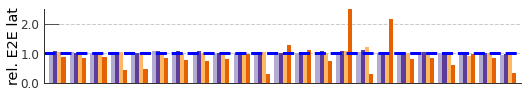

In [21]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_polybench)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_polybench)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork','faasm']], ['GH-NOP', 'GH', 'fork','faasm'], "", "rel. E2E lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = None, outname="vs_native_polybench-latency", bench_names=False, legend=False,fig_size=(7.5,1.5), ylim = 2.5, out_dir=out_dir)

In [22]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_python)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_python)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork']], ['GH-NOP', 'GH', 'fork'], "FaaSProfiler (python)", "rel. inv. lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = None, outname="vs_native_python-inv-latency-names", bench_names=True, fig_size=(3,1.5), ylim=2.5, legend_cols=2, legend=False, out_dir=out_dir)

/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])
/local/workspace/automation/plot/utils.py:439: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])


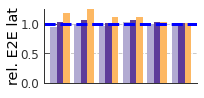

In [23]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_python)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_python)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork']], ['GH-NOP', 'GH', 'fork'], "", "rel. E2E lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = False, outname="vs_native_python-latency", bench_names=False, fig_size=(3,1.5), ylim=1.25, legend_cols=2, legend=False, out_dir=out_dir)

/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])
/local/workspace/automation/plot/utils.py:439: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


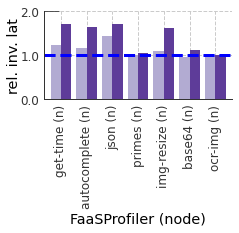

In [24]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_node)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_node)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH']], ['GH-NOP', 'GH'], "FaaSProfiler (node)", "rel. inv. lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = False, outname="vs_native_node-inv-latency-names", bench_names=True, fig_size=(3,1.5), ylim=2, legend_cols=2, legend=False, out_dir=out_dir)

/local/workspace/automation/plot/utils.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(x) for x in current_y_values])


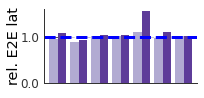

In [25]:
df_grouped2_pivot_m = m.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_node)
df_grouped2_pivot_e = e.pivot_table(index='name', columns='type', values='end_end_latency').reindex(grand_table_node)
df_grouped2_pivot_m['faasm'] = df_grouped2_pivot_m['faasm']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH']], ['GH-NOP', 'GH'], "Benchmark", "rel. E2E lat", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = False, outname="vs_native_node-latency", bench_names=False, fig_size=(3,1.5), ylim=1.6, legend_cols=2, legend=False, out_dir=out_dir)

# Decomposition of overheads (Groundhog)

In [26]:
data_inst_poly_file = [f for f in glob(data_root_dir + dirs['ow']['latency']['polybench']+ os.sep + "*/**/*-docker-logs.json", recursive=True) if 'groundhog-sd' in f]
data_inst_pyperf_file = [f for f in glob(data_root_dir + dirs['ow']['latency']['pyperf']+ os.sep + "*/**/*-docker-logs.json", recursive=True) if 'groundhog-sd' in f]
data_inst_python_file = [f for f in glob(data_root_dir + dirs['ow']['latency']['python']+ os.sep + "*/**/*-docker-logs.json", recursive=True) if 'groundhog-sd' in f]
data_inst_node_file = [f for f in glob(data_root_dir + dirs['ow']['latency']['node']+ os.sep + "*/**/*-docker-logs.json", recursive=True) if 'groundhog-sd' in f]


In [27]:
all_inst_dirs = [data_inst_poly_file, data_inst_pyperf_file, data_inst_python_file, data_inst_node_file]
logs_files = [item for sublist in all_inst_dirs for item in sublist]

In [28]:
def prepare_dataframe(df_json, benchmark_name):
    try:
        df = pd.DataFrame(df_json)
        df.name = df.name.str.replace(r"\(.*\)","")
        df.name = df.name.str.strip()    
        df['mean_ms'] = df['mean']/1e6 #in ms
        df['max_ms'] = df['max']/1e6 #in ms
        df['min_ms'] = df['min']/1e6 #in ms
        df['stddev_ms'] = df['stddev']/1e6 #in ms
        df['sum_ms'] = df['sum']/1e6 #in ms    
        df["Benchmark"] = benchmark_name
        return df
    except Exception as e:
        #print(e)
        return None


In [29]:
all_dfs = []
datasets = []
#logs_files = [f for f in logs_files if "pyperf-version" in f]
for i, file in enumerate(reversed(logs_files)):
    with open(file) as f:
        base=os.path.basename(file)
        name=os.path.splitext(base)[0]
        name=os.path.splitext(name)[0].replace("-docker-logs","")
        buf = f.read().replace("XXX_THE_END_OF_A_WHISK_ACTIVATION_XXX\n", "")
        buf = re.sub(r'3.8.2 \(default, Apr.*\n', '', buf)
        buf = re.sub(r'\[GCC 8.3.0\]\n', '', buf)
        #print(buf)
        buf = re.sub(r'^\(.*\n', '', buf)
        buf = re.sub(r'^\(.*\n', '', buf)
        buf = re.sub(r'^load.*\n', '', buf)
        buf = re.sub(r'bash.*\n', '', buf)
        #if name not in datasets:
        try:
            df = prepare_dataframe(pd.json_normalize(json.loads(buf)['xstats']), name)
            df["iteration"] = i
            #print(df)
            if df is not None:
                all_dfs.append(df)
                datasets.append(name)
        except Exception:
            try:
                with open(file.replace("-docker-logs","-logs")) as f:
                    buf = f.read()
                    buf = re.sub(r'.{30} stderr:', '\r\n', buf)
                    buf = re.sub(r'\\"', '"', buf)
                    buf = re.sub(r'", "', '', buf)
                    buf = re.sub(r'}"|\["', '[', buf)
                    buf = re.sub(r'\[\]', '}]', buf)
                    #print(buf)
                    df = prepare_dataframe(pd.json_normalize(json.loads(buf)['logs'][0]['xstats']), name)
                    df["iteration"] = i
                    #print(df)
                    if df is not None:
                        all_dfs.append(df)
                        datasets.append(name)
            except Exception as e:
                print(e)
                print("No logs:", file) 
df = pd.concat(all_dfs)
df_timings = df[df.name.str.contains("Time")]
df_counts = df[df.name.str.contains("umber")]

/tmp/ipykernel_3623465/4134554566.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.name = df.name.str.replace(r"\(.*\)","")


Expecting ',' delimiter: line 1 column 15 (char 14)
No logs: /local/workspace/automation/benchmarks/benchmarks/EUROSYS23-DATA/latency/latency-node-no-gc/2022_01_10-18_42_04_groundhog-sd/base64-node-docker-logs.json
Expecting value: line 1 column 10 (char 9)
No logs: /local/workspace/automation/benchmarks/benchmarks/EUROSYS23-DATA/latency/latency-node-no-gc/2022_01_08-13_51_33_groundhog-sd/base64-node-docker-logs.json


In [30]:
snapshot_deconstruction = ["Time for seizing",
             "Time for interrupting",
             "Time for storing registers",
             "Time for reading maps",
             "Time for reading pages metadata",
             "Time for saving a copy of writable memory",
             "Time for detaching"]
snapshot_df = df.query("name in @snapshot_deconstruction")

In [31]:
restore_deconstruction = ["Time for interrupting", 
             "Time for reading maps",
             "Time for reading pages metadata",
             "Time for diffing 2 snapshots",
             'Time for brk syscall',
             'Time for mmaping a region',
             'Time for unmmaping a region',
             'Time for madvising pages',
             'Time for mprotecting a region',
             "Time for restoring writable memory",
             "Time for clearing soft dirty bits",
             "Time for restoring registers",
             "Time for detaching"]
restore_df = df.query("name in @restore_deconstruction")
def row_func(row, field):
    # 'Time for reading pages' in row.name:
    #'Time for diffing 2 snapshots' in row.name
    
    if 'Time for reading maps' in row.name or 'Time for diffing 2 snapshots' in row.name:
        return row[field] #* 2
    else:
         return row[field]
        
restore_df = restore_df.reset_index().set_index(["Benchmark","name","iteration"])
total_restoration = df.query("name in 'Sec-FaaS all inclusive restore iteratinon time'")
total_snapshot = df.query("name in 'Sec-FaaS all inclusive checkpoint iteratinon time'")

In [32]:
memory_names = ["Number of pages", 
                "Number of paged pages", 
                "Number of writable pages",
                "Number of restored pages",
                "Number of soft-dirty paged pages",
                "SEC-FaaS memory footprint"]
memory_cost_df = df.reset_index().query("name in @memory_names")[["Benchmark", "name", "min", "mean", "max", "stddev"]]
memory_cost_df[["min", "mean", "max", "stddev"]] = memory_cost_df[["min", "mean", "max", "stddev"]] / 1e3

memory_cost_df_data = pd.pivot_table(benchmarks_renamer(memory_cost_df.reset_index()), index='Benchmark', columns='name', values='mean', aggfunc=np.mean)
memory_cost_df_data_stddev = pd.pivot_table(memory_cost_df.reset_index(), index='Benchmark', columns='name', values='stddev', aggfunc=np.mean)


findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.


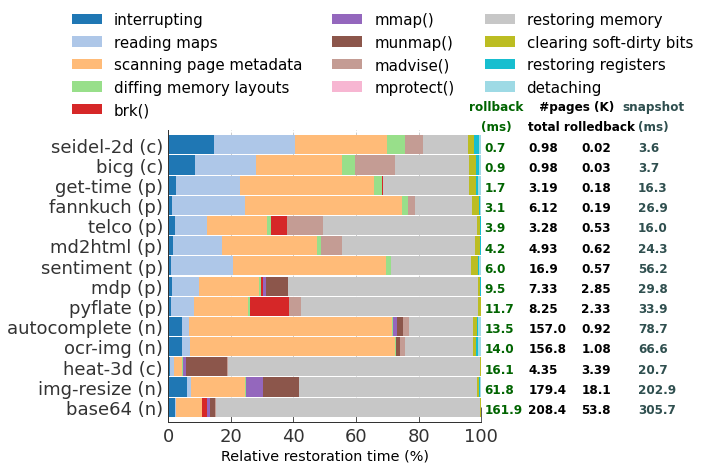

In [33]:
total_restoration = restore_df.groupby(["Benchmark","iteration"]).sum()
deconst_restoration = restore_df[["sum"]].reset_index().groupby(["Benchmark","name", "iteration"]).mean()
total_chkpt = total_snapshot.groupby(["Benchmark"]).mean()["mean"].reindex(decomposition_benchmarks)

merged_df = deconst_restoration.reset_index().merge(total_restoration.reset_index(), on=["Benchmark", "iteration"])[["Benchmark", "name", "sum_x", "sum_y"]]
merged_df["percentage"] = 100* merged_df["sum_x"]/ merged_df["sum_y"]
merged_plt_data = merged_df[["Benchmark", "name", "percentage"]].groupby(["Benchmark","name"]).mean().reindex(restore_deconstruction, level=1).unstack()
merged_plt_data.columns = merged_plt_data.columns.droplevel()
renaming = {"Time for interrupting":"interrupting", 
             "Time for reading maps":"reading maps",
             "Time for reading pages metadata":"scanning pages metadata",
             "Time for diffing 2 snapshots":"diffing memory layouts",
             'Time for brk syscall':'brk()',
             'Time for mmaping a region':'mmap()',
             'Time for unmmaping a region':'munmap()',
             'Time for madvising pages':'madvise()',
             'Time for mprotecting a region':'mprotect()',
             "Time for restoring writable memory":"restoring memory",
             "Time for clearing soft dirty bits":"clearing soft-dirty bits",
             "Time for restoring registers":"restoring registers",
             "Time for detaching":"detaching"}
ax = benchmarks_renamer(merged_plt_data.rename(columns = renaming).reset_index()).set_index('Benchmark') \
    .reindex(list(benchmarks_renamer(pd.Series(decomposition_benchmarks)))) \
    .plot(kind='barh', figsize=(5,5), stacked=True, colormap='tab20', width=0.95, fontsize='18')

handles, labels = ax.get_legend_handles_labels()
for l in range(len(labels)):
    labels[l] = re.sub("scanning pages metadata","scanning page metadata",labels[l])
plt.legend(handles, labels, prop={'size': 15}, loc='upper left', bbox_to_anchor=(-0.35, 1.45), ncol=3,framealpha=0)
plt.xlabel("Relative restoration time (%)")
plt.ylabel("")
#plt.tight_layout(pad=0, h_pad=0)

plt.xlim([0,100])

gh_inv_latency = df_latency_ow.query(f"invocation_type == 'warm' and type in 'warm-groundhog-sd'")[['name','duration','TrueTime']].groupby(['name']).mean().reindex(decomposition_benchmarks)
gh_inv_latency['TrueTime'] = gh_inv_latency['TrueTime'] / 1e6
gh_nop_inv_latency = df_latency_ow.query(f"invocation_type == 'warm' and type in 'warm-gh-nop'")[['name','duration','TrueTime']].groupby(['name']).mean().reindex(decomposition_benchmarks)
gh_nop_inv_latency['TrueTime'] = gh_nop_inv_latency['TrueTime'] / 1e6
baseline_inv_latency = df_latency_ow.query(f"invocation_type == 'warm' and type in 'warm-baseline'")[['name','duration','TrueTime']].groupby(['name']).mean().reindex(decomposition_benchmarks)
baseline_inv_latency['TrueTime'] = baseline_inv_latency['TrueTime'] / 1e6

ax.text(96, 14.7, "rollback", color='darkgreen', fontweight='bold')
ax.text(100, 13.7 , "(ms)", color='darkgreen', fontweight='bold')

ax.text(117, 14.7, " #pages (K)", color='black', fontweight='bold')
ax.text(115, 13.7 , "total rolledback", color='black', fontweight='bold')
ax.text(145, 14.7, "snapshot", color='darkslategray', fontweight='bold')
ax.text(150, 13.7 , "(ms)", color='darkslategray', fontweight='bold')

memory_costs = memory_cost_df_data.reindex(list(benchmarks_renamer(pd.Series(decomposition_benchmarks))))
for i, v in enumerate(total_restoration.groupby(["Benchmark"]).mean()["mean"].reindex(decomposition_benchmarks)):
    ax.text(101, i-0.3 , str(round(v/1e6,1)), color='darkgreen', fontweight='bold')
    ax.text(115, i-0.3, str(smart_round(memory_costs['Number of pages'][i])), color='black', fontweight='bold')
    ax.text(132, i-0.3,  str(smart_round(memory_costs['Number of restored pages'][i])), color='black', fontweight='bold')
    ax.text(150, i-0.3, str(round(total_chkpt[i]/1e6,1)), color='darkslategray', fontweight='bold')


plt.savefig(out_dir + os.sep + "decomposition-restoration-latency-percentage.png",bbox_inches="tight")
plt.savefig(out_dir + os.sep + "decomposition-restoration-latency-percentage.pdf",bbox_inches="tight")

# Reset latency comparison (GH vs Faasm)

In [34]:
faasm_reset = benchmarks_renamer(df_faasm_invoker_latency.replace(["pyperf-", "bench_", "poly_", "polybench-", "-python", "-c$", "-node", "-t.-", "-t. "],
                                          ["", "", "", "", " (p)", " (c)", " (n)", "-", " "],regex=True).reset_index())[['name','Reset (us)']].groupby(['name']).mean().reindex(grand_table_order)

faasm_reset['Reset (us)'] = faasm_reset['Reset (us)']/1e3
faasm_reset.columns = ['reset (ms)']


In [35]:
faasm_latency_reset_df = benchmarks_renamer(full_latency_df.query('type == "faasm" and duration > 0'))
all_faasm_benchmarks = faasm_latency_reset_df.name.unique()
gh_latency_reset_df = benchmarks_renamer(total_restoration.reset_index()[['Benchmark', 'mean_ms']])
gh_latency_reset_df['type'] = "GH"
plot_data_faasm_reset = pd.concat([faasm_latency_reset_df.rename(columns={'name':'Benchmark'})[['Benchmark', 'mean_ms', 'type']], 
                                   gh_latency_reset_df[['Benchmark', 'mean_ms', 'type']]])

In [36]:
df_grouped = plot_data_faasm_reset.groupby(['Benchmark', 'type'])

color_palette = ['#b2abd2', '#5e3c99', '#fdb863', '#e66101']
colors=['#a6d96a', 'green']

In [37]:
bar_plot_reset(df_grouped, ['GH','faasm'], "pyperformance", "Restoration (ms)", "", colors=['#5e3c99','#e66101'],
         outname="reset-gh-faasm-p", all_benchmarks=grand_table_pyperf, figsize=(7.5,2), out_dir=out_dir)


/home/secfaas/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [38]:
bar_plot_reset(df_grouped, ['GH','faasm'], "PolyBench", "Restoration (ms)", "", colors=['#5e3c99','#e66101'],
         outname="reset-gh-faasm-c", all_benchmarks=grand_table_polybench, figsize=(7.5,2), out_dir=out_dir)

/home/secfaas/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


# Throughput Macrobenchmarks

#### Prepare xput dfs (OW)

In [39]:
data_xput_poly_file = glob(data_root_dir + dirs['ow']['xput']['polybench']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_xput_pyperf_file = glob(data_root_dir + dirs['ow']['xput']['pyperf']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_xput_python_file = glob(data_root_dir + dirs['ow']['xput']['python']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_xput_node_file = glob(data_root_dir + dirs['ow']['xput']['node']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]

In [40]:
df_xput_poly = pd.read_csv(data_xput_poly_file)
df_xput_pyperf = pd.read_csv(data_xput_pyperf_file)
df_xput_python = pd.read_csv(data_xput_python_file)
df_xput_node = pd.read_csv(data_xput_node_file)
df_xput_ow = pd.concat([df_xput_poly, df_xput_pyperf, df_xput_python, df_xput_node])

In [41]:
ow_thpt_raw_data = df_xput_ow.query('invocation_type == "warm"').groupby(['name', 'type', 'iteration'])
xput_ow_table_data = ow_thpt_raw_data.apply(lambda group: calculate_xput_cores(group.sort_values(by='start'))).reset_index().rename(columns={0: "xput"}).groupby(['name', 'type'])

In [42]:
ow_xput = xput_ow_table_data.mean()[['xput']].unstack(level=1).reset_index()
ow_xput_std = xput_ow_table_data.std()[['xput']].unstack(level=1).reset_index()
ow_xput.columns = ow_xput.columns.droplevel()
ow_xput_std.columns = ow_xput_std.columns.droplevel()

In [43]:
# logging has a memory leak and terminates, it doesn't sustain xput
ow_xput.loc[ow_xput[''] == "pyperf-logging-python", 'warm-baseline'] = 0
ow_xput.loc[ow_xput[''] == "pyperf-logging-python", 'warm-gh-nop'] = 0

In [44]:
full_xput_df = ow_xput

In [45]:
total_restoration = restore_df.groupby(["Benchmark","iteration"]).sum().reset_index()
restoration_df = round(total_restoration.groupby(["Benchmark"]).mean()[["mean"]] / 1e6,2)
restoration_df = restoration_df.reset_index().rename(columns={"mean":"restoration"})

In [46]:
test_df_xput_inference = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_pyperf).join(benchmarks_renamer(restoration_df).set_index("Benchmark").reindex(grand_table_pyperf))
test_df_xput_inference["xput ratio"] = \
test_df_xput_inference['warm-baseline'] / (test_df_xput_inference['warm-GH']+test_df_xput_inference['restoration'])

findfont: Font family ['Clear Sans'] not found. Falling back to DejaVu Sans.


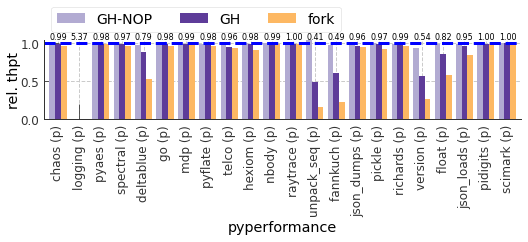

In [47]:
df_grouped2_pivot_m = benchmarks_renamer(ow_xput).rename(columns = {"":"Benchmark",
                                   "warm-gh-nop":"warm-GH-NOP",
                                   "warm-groundhog-sd":"warm-GH"}).set_index("Benchmark").reindex(grand_table_pyperf)
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork']], ['GH-NOP', 'GH', 'fork'], "pyperformance", "rel. thpt", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = False, outname="vs_native_pyperf-xput", ylim=1.05, legend=True, fig_size=(7.5,5), format_y=False, xput_ratios=test_df_xput_inference["xput ratio"], print_actual_ratios=False, out_dir=out_dir)


In [48]:
test_df_xput_inference = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_polybench).join(benchmarks_renamer(restoration_df).set_index("Benchmark").reindex(grand_table_polybench))
test_df_xput_inference["xput ratio"] = \
test_df_xput_inference['warm-baseline'] / (test_df_xput_inference['warm-GH']+test_df_xput_inference['restoration'])

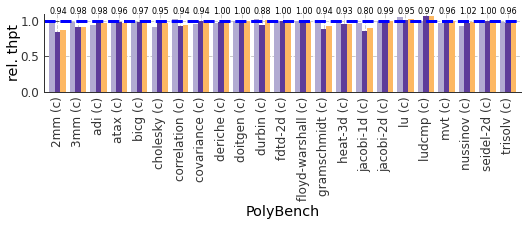

In [49]:
df_grouped2_pivot_m = benchmarks_renamer(full_xput_df).rename(columns = {"":"Benchmark",
                                   "warm-gh-nop":"warm-GH-NOP",
                                   "warm-groundhog-sd":"warm-GH"}).set_index("Benchmark").reindex(grand_table_polybench)
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork']], ['GH-NOP', 'GH', 'fork'], "PolyBench", "rel. thpt", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = False, outname="vs_native_polybench-xput-no-faasm", ylim=1.1, legend=False, fig_size=(7.5,3.3), format_y=False,xput_ratios=test_df_xput_inference["xput ratio"], print_actual_ratios=False, out_dir=out_dir)

In [50]:
test_df_xput_inference = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_python).join(benchmarks_renamer(restoration_df).set_index("Benchmark").reindex(grand_table_python))
test_df_xput_inference["xput ratio"] = \
test_df_xput_inference['warm-baseline'] / (test_df_xput_inference['warm-GH']+test_df_xput_inference['restoration'])

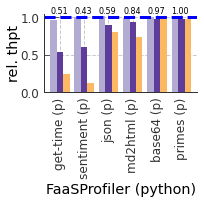

In [51]:
df_grouped2_pivot_m = benchmarks_renamer(full_xput_df).rename(columns = {"":"Benchmark",
                                   "warm-gh-nop":"warm-GH-NOP",
                                   "warm-groundhog-sd":"warm-GH"}).set_index("Benchmark").reindex(grand_table_python)
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH', 'fork']], ['GH-NOP', 'GH', 'fork'], "FaaSProfiler (python)", "rel. thpt", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = None, outname="vs_native_python-xput", ylim=1.05, legend=False,fig_size=(3,3), format_y=False,xput_ratios=test_df_xput_inference["xput ratio"], print_actual_ratios=False, out_dir=out_dir)


In [52]:
test_df_xput_inference = m.pivot_table(index='name', columns='type', values='duration').reindex(grand_table_node).join(benchmarks_renamer(restoration_df).set_index("Benchmark").reindex(grand_table_node))
test_df_xput_inference["xput ratio"] = \
test_df_xput_inference['warm-baseline'] / (test_df_xput_inference['warm-GH']+test_df_xput_inference['restoration'])


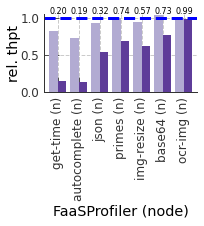

In [53]:
df_grouped2_pivot_m = benchmarks_renamer(full_xput_df).rename(columns = {"":"Benchmark",
                                   "warm-gh-nop":"warm-GH-NOP",
                                   "warm-groundhog-sd":"warm-GH"}).set_index("Benchmark").reindex(grand_table_node)
df_grouped2_pivot_m['GH'] = df_grouped2_pivot_m['warm-GH']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['GH-NOP'] = df_grouped2_pivot_m['warm-GH-NOP']/df_grouped2_pivot_m['warm-baseline']
df_grouped2_pivot_m['fork'] = df_grouped2_pivot_m['warm-forkline']/df_grouped2_pivot_m['warm-baseline']
bar_plot_relative(df_grouped2_pivot_m[['GH-NOP', 'GH']], ['GH-NOP', 'GH'], "FaaSProfiler (node)", "rel. thpt", log=False, title="", numbers=False, colors=color_palette, 
                  hatches = None, outname="vs_native_node-xput", ylim=1.05, legend=False,fig_size=(3,3.3), format_y=False,xput_ratios=test_df_xput_inference["xput ratio"], print_actual_ratios=False, out_dir=out_dir)


# Scaling Macrobenchmarks

In [54]:
data_scaling_1cpu_file = glob(data_root_dir + dirs['ow']['scaling']['1']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_scaling_2cpu_file = glob(data_root_dir + dirs['ow']['scaling']['2']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_scaling_3cpu_file = glob(data_root_dir + dirs['ow']['scaling']['3']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]
data_scaling_4cpu_file = glob(data_root_dir + dirs['ow']['scaling']['4']+ os.sep + "*/**/activations-data.csv", recursive=True)[0]

In [55]:
df_ow_scaling_1 = pd.read_csv(data_scaling_1cpu_file)
df_ow_scaling_2 = pd.read_csv(data_scaling_2cpu_file)
df_ow_scaling_3 = pd.read_csv(data_scaling_3cpu_file)
df_ow_scaling_4 = pd.read_csv(data_scaling_4cpu_file)
df_ow_scaling = pd.concat([df_ow_scaling_1, df_ow_scaling_2, df_ow_scaling_3, df_ow_scaling_4])

In [56]:
df_ow_scaling_grouped = df_ow_scaling.query('invocation_type == "warm"').replace(["warm-"],[""],regex=True).groupby(['name', 'type', 'iteration', 'num_containers'])
df_ow_scaling_core_xput = df_ow_scaling_grouped.apply(lambda group: calculate_xput_cores(group.sort_values(by='start'))).reset_index()

In [57]:
benchmarks_scaling = ['get-time-python','autocomplete-node', 'pyperf-fannkuch-python',
                      'sentiment-analysis-python', 'markdown-to-html-python','polybench-bicg-c',
                'pyperf-telco-python','img-resize-node','base64-node', 'pyperf-pyflate-python', 
                'ocr-img-node', 'polybench-heat-3d-c', 'pyperf-mdp-python',
                'polybench-seidel-2d-c']

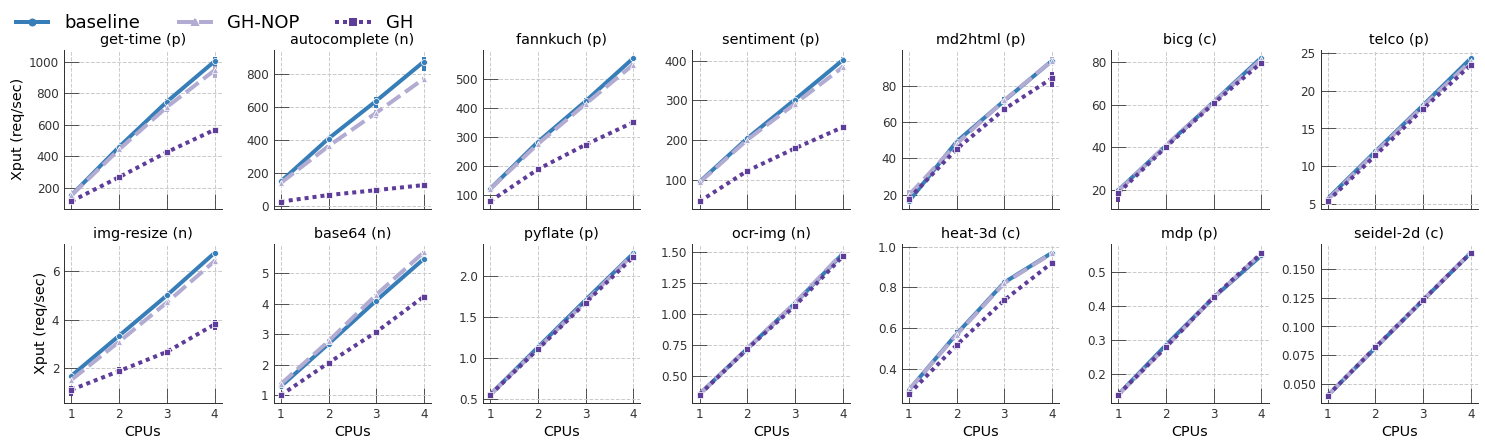

In [58]:
color_palette = ['#377eb8', '#b2abd2', '#5e3c99']# '#fdb863', ]
bench_order = list(benchmarks_renamer(pd.Series(benchmarks_scaling)))
with sns.plotting_context(font_scale=5):
    facet_grid_plot_data = benchmarks_renamer(df_ow_scaling_core_xput)#.groupby(['name','type','num_containers']).mean().reset_index())
    g = sns.FacetGrid(facet_grid_plot_data, col="name", col_wrap=7, col_order=bench_order, sharey=False)
    g.map_dataframe(sns.lineplot, x="CPUs", y="xput", hue="type", style="type", markers=["o","^","s"], ci=100 ,err_style='bars', palette = color_palette)
    g.add_legend(prop={'size': 18}, loc='upper left', bbox_to_anchor=(0, 1.05), ncol=3)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()
    g.set_ylabels("Xput (req/sec)")
    g.savefig(out_dir + os.sep + "gh-scaling-paper.png",bbox_inches="tight")
    g.savefig(out_dir + os.sep +"gh-scaling-paper.pdf",bbox_inches="tight")